<a href="https://colab.research.google.com/github/BelenKohl/SRMP/blob/main/Cluster_Isochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Numpy: arrays, numbers, constants, math
import numpy as np

# Matplotlib: plotting
import matplotlib.pyplot as plt

# This disables certain system messages
import warnings
warnings.filterwarnings('ignore')

# Accessing astronomical datasets
!pip install astroquery
from astroquery.vizier import Vizier

# Reading and working with Astropy tables
from astropy.io import ascii

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.2/910.2 kB 25.1 MB/s eta 0:00:00


In [2]:
def get_cluster(Cluster_Name):
  vizier_CantatGaudin2020 = 'J/A+A/640/A1/nodup'    # Cantat-Gaudin et al. (2020) - this is the vizier code for the "Portrait" paper.

  # Set up the Vizier query.
  # First, we want to select only stars in the cluster we are interested in.
  # Second, Cantat-Gaudin+2020 also provides membership probabilities (ranging from 0 to 1).
  #   We will only download stars with membership probabilities greater than 50%.
  query_catalog = Vizier(column_filters={'Cluster': Cluster_Name, 'prob':'>0.5'})

  # By default, Vizier() only downloads the first 50 rows of a table.
  # To deactivate the row limit, set it to -1 (i.e., this will tell it to download the full table)
  query_catalog.ROW_LIMIT = -1

  # Perform the query
  cluster_catalog = query_catalog.get_catalogs(vizier_CantatGaudin2020)[0]

  # Rename some of the columns to simpler names
  cluster_catalog['pmRA_'].name = 'pmRA'
  cluster_catalog['pmDE'].name = 'pmDec'
  cluster_catalog['Plx'].name = 'Parallax'
  cluster_catalog['RA_ICRS'].name = 'RA'
  cluster_catalog['DE_ICRS'].name = 'Dec'

  # Remove some unnecessary columns
  cluster_catalog.remove_columns(['o_Gmag', 'proba', 'Cluster', '_RA.icrs', '_DE.icrs','Teff50'])

  # Return the catalog
  return cluster_catalog

In [3]:
# The URL where we have placed the modified isochrone file
url = "https://github.com/jasoncurtis/Lessons/blob/main/GaiaDR2_Isochrones.dat?raw=true"
# Read the file using astropy.ascii.read()
isochrone_table = ascii.read(url, delimiter=r'\s')

In [4]:
# Define a function that locates the place in an array where the entry is closest to a requested value:
def find_element(value, array):
  absolute_difference = abs(array - value)
  location_of_element_nearest_to_value = np.argmin(absolute_difference)
  return location_of_element_nearest_to_value

# Define a function that pulls out one isochrone (one age) out of the grid.

# This function will also introduce interstellar extinction (dims Gmag) and reddening (increases BP-RP).
# This is parameterized with $A_V$, the extinction in the visual $V$ band.
# The extinction in other bands can be calculated from A_V using "extinction coefficients"


def get_isochrone(age, Av = 0.0):
  # Note: Input age must be in millions of years (Myr)

  #
  unique_ages_in_isochrone_table = np.unique(isochrone_table['log_Age'])

  #
  location_of_nearest_age_in_isochrone = find_element(age, 10**unique_ages_in_isochrone_table/1e6)

  #
  nearest_age_in_isochrone = unique_ages_in_isochrone_table[location_of_nearest_age_in_isochrone]

  #
  find_matching_ages = np.where((isochrone_table['log_Age'] == nearest_age_in_isochrone) &
                                (isochrone_table['label']<7)
                                )[0]

  # extract isochrone at the given age
  isochrone_at_input_age = isochrone_table[find_matching_ages]

  #
  isochrone_at_input_age['BP-RP'] = isochrone_at_input_age['G_BPmag'] - isochrone_at_input_age['G_RPmag']

  # Correct photometry for interstellar reddening and extinction
  isochrone_at_input_age['Gmag'] += 0.86*Av
  isochrone_at_input_age['BP-RP'] += 0.415*Av

  isochrone_at_input_age.remove_columns(['G_BPmag', 'G_RPmag'])

  # return
  return isochrone_at_input_age



In [5]:
# calculate absolute magnitude
def m_to_M(m, D):
    """
    Convert apparent magnitude to absolute magnitude.
    """
    return m - 5*np.log10(D)-10

In [39]:
Pleiades = get_cluster('haffner_3')

Text(0, 0.5, '$M_G$')

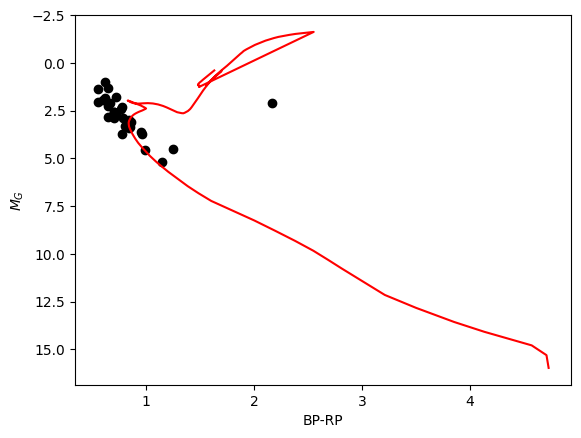

In [60]:
Age = 1800 # Myr -- modify this number and Av until you get a good fit
Av = 0.8 # mag  -- modify this number and Age above until you get a good fit
my_isochrone = get_isochrone(Age, Av=Av)

plt.plot(Pleiades['BP-RP'], m_to_M(Pleiades['Gmag'], 1/Pleiades['Parallax']), 'ko')
plt.plot(my_isochrone['BP-RP'], my_isochrone['Gmag'], 'r-')
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('$M_G$')

In [8]:
Pleiades

RA,Dec,GaiaDR2,Parallax,pmRA,pmDec,RV,Gmag,BP-RP,Simbad
deg,deg,,mas,mas / yr,mas / yr,km / s,mag,mag,
float64,float64,int64,float64,float64,float64,float64,float64,float64,str6
57.35702479597,41.57904985021,231129477446178944,5.7083185817826161,20.9794530964837413,-27.7561907591321528,--,16.6027720,2.9433632,Simbad
58.05039818453,42.39184549391,231272517037288192,5.6105456915096532,20.1424158936030935,-27.1073318823840452,--,15.6953750,2.6243477,Simbad
60.45095664395,43.18663168097,231553201741055488,5.7858590702130694,20.2750090924745798,-28.3554286642096613,--,17.3586310,3.148367,Simbad
59.86412496281,43.55840142178,231614499513678464,5.665865781553066,20.0139084180970599,-27.7699995077960864,11.7965154451117619772,12.5289890,1.298686,Simbad
59.31512281245,44.30920937175,231889927176318720,5.4873933337112861,19.6109949316015104,-26.8313989367438417,--,14.4470360,2.0646982,Simbad
61.21985456744,45.28962311770,233412201025744512,5.7620965639212365,19.3238666776732906,-26.8473374929402375,--,17.6734640,--,Simbad
60.93711843107,45.31359966391,233461575969830528,5.7183706752417391,19.2990116608767686,-27.8336841833250084,--,15.4558800,2.515749,Simbad
53.61145105779,40.25899201530,236674383305271680,5.4204018947792196,20.3092503330286078,-24.0423479620814504,--,14.7290880,2.223918,Simbad
